In [179]:
import sys

sys.path.append('C:\\Users\\erik_\\Documents\\erik documents\\Programas\\PlasmaSimulations\\src')
# sys.path.append('...\\PlasmaSimulations\\src') # Replace dots with personal directory

%matplotlib inline
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.animation as animation
# plt.rcParams['animation.html'] = 'html5'

from IPython import display
import time
import ffmpeg

import VlasovSolver

# Landau damping

### Initial Condition of the model:

$$ f(0,x,v) =  \frac{1}{\sqrt{2 \pi}} e^{-v^2/2} (1+\varepsilon\cos(kx))$$

Where $\varepsilon$ controls the perturbation, values of $\varepsilon < 0.5$ leads to a linear Landau Damping whilst $\varepsilon \geq 0.5$ leads to the non linear Landau damping. $k$ is the wave number.

## 1. Non Linear Landau Damping 

#### Parameters

- $\varepsilon$ = 0.5
- $k$ = 0.5
- $v\in(-10,10)$
- $x\in(0,2\pi/k)$

In [180]:
eps = 0.5 # perturbation parameter
v_min = -10 # Minimum velocity 
v_max = 10 # Maximum velocity
T_max = 35 # Max time of solution
k_param = 0.5 # wave number
L_x = 2*np.pi / k_param # Size of grid
L_x

12.566370614359172

#### Initial Condition

In [181]:
def landau_initial_cond(x,v):
    return (1.0/np.sqrt(2.0*np.pi)) * np.exp(-v**2/2.0) * (1.0 + eps*np.cos(k_param*x))

#### Discretization

In [182]:
N_x = 256 # Position Slots 
N_y = 256 # Velocities Slots 
M_size = 6000 # Divisions of time in M slots 

# Step Sizes:
dx = L_x/N_x
dv = (v_max-v_min)/N_y
dt = T_max/M_size

print(f'Nx: {N_x}     dx: {dx}')
print(f'Ny: {N_y}    dy: {dv}')
print(f'M:  {M_size}   dt: {dt}')

Nx: 256     dx: 0.04908738521234052
Ny: 256    dy: 0.078125
M:  6000   dt: 0.005833333333333334


#### Run Model

In [40]:
start_time = time.time()

objSolver = VlasovSolver.VlasovPoisson1D1V(landau_initial_cond, 0.0 ,L_x , N_x, v_min, v_max, N_y, T_max, M_size, 
                                                 'Spectral', 1 ,'Landau_Damping1')
Mass_sol,Moment_sol,Energy_sol,L2norm_sol,E_field = objSolver.run_iteration() # run model

end_time = time.time()
print('Total execution time: ',(end_time-start_time)/60.)

Total execution time:  12.23392497698466


In [183]:
t_grid = objSolver.grid_points(0.0,T_max,dt)[:-1]
t_grid.shape

(6000,)

### Plot the variables evolution in time (Mass, Momentum, Energy and $L^2$ Norm)

In [184]:
def plot_quantity(t_array,var_array,label,var_name,dtime):
    plt.figure(figsize=(10,8))
    plt.plot(t_array,var_array,label = label,c='b')
    plt.title(f"Conservation of Total {var_name} for dt: "+ "%.3f"%dtime,fontsize=15)
    plt.xlabel('Time',fontsize=14)
    plt.ylabel(f'{var_name}',fontsize=14)
    plt.legend()
    plt.show()

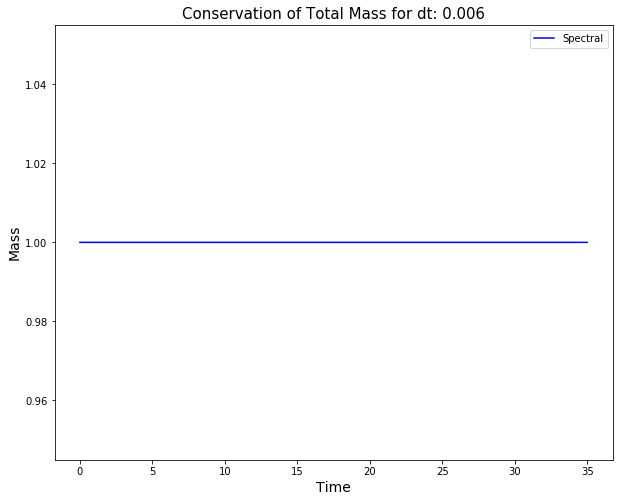

In [185]:
plot_quantity(t_grid,Mass_sol/Mass_sol[0],'Spectral','Mass',dt)

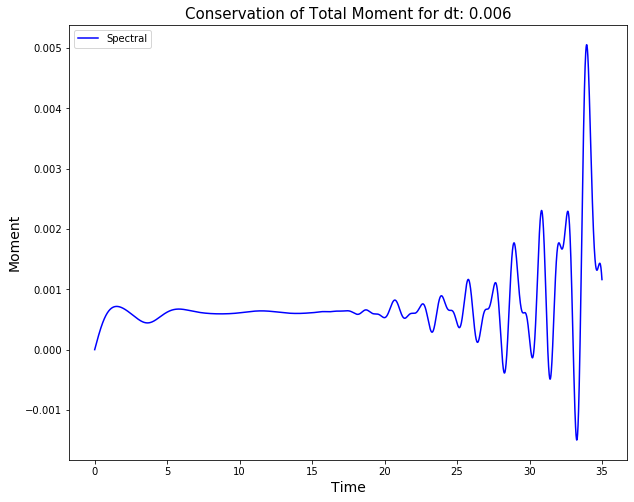

In [186]:
plot_quantity(t_grid,Moment_sol,'Spectral','Moment',dt)

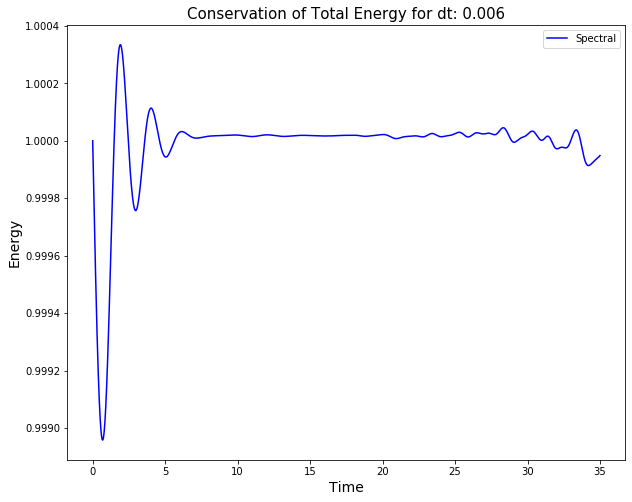

In [187]:
plot_quantity(t_grid,Energy_sol/Energy_sol[0],'Spectral','Energy',dt)

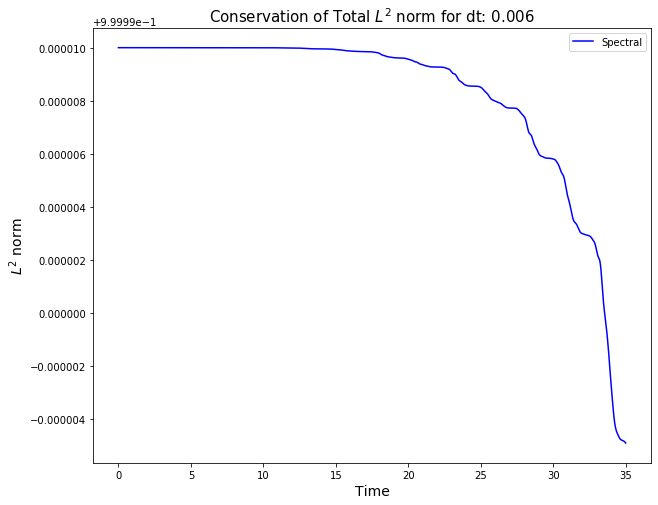

In [188]:
plot_quantity(t_grid,L2norm_sol/L2norm_sol[0],'Spectral','$L^2$ norm',dt)

### Open File

In [47]:
data_Landau1 = np.loadtxt("Landau_Damping1.txt")
data_Landau1 = data_Landau1.reshape(M_size+1,N_y+1,N_x+1)
data_Landau1.shape

(6001, 257, 257)

### Plot the distribution function

In [189]:
x_array = np.arange(0, L_x + dx, dx) # positions array
v_array = np.arange(v_min, v_max + dv, dv) # velocities array
Pos,Vel = np.meshgrid(x_array,v_array) # space-velocity mesh grid

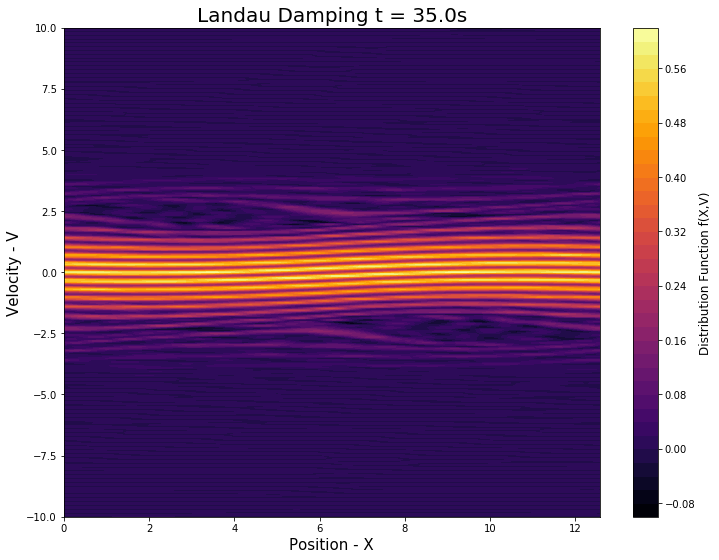

In [190]:
fig,ax = plt.subplots(1,1,figsize = (12, 9))
ti = 6000 # time to plot
cp = ax.contourf(Pos, Vel , data_Landau1[ti],40, cmap=cm.inferno) # Create contour plot
cbar = fig.colorbar(cp) # Add a colorbar to a plot
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12) # Label the color bar
plt.title(f'Landau Damping t = {ti*dt}s',fontsize = 20) # title
ax.set_xlabel('Position - X',fontsize = 15) # xlabel
ax.set_ylabel('Velocity - V',fontsize = 15) # ylabel
plt.show()

In [191]:
time_plot = [0, 1200, 2400, 3600, 4800, 6000] #times to plot

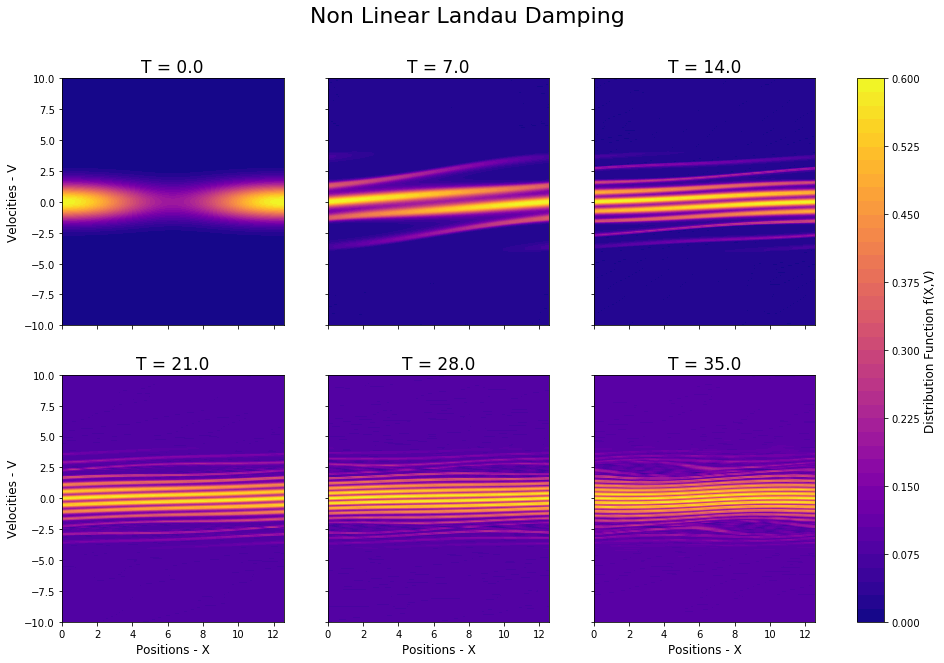

In [192]:
### Create plots of the distribution function at different times

fig, ax = plt.subplots(2, 3,figsize=(15,10))
fig.suptitle('Non Linear Landau Damping',fontsize = 22) # general title

ti = 0 # index counter
images = [] # list to store images

for i in range(2): 
    for j in range(3):
        cp = ax[i,j].contourf(Pos, Vel, data_Landau1[time_plot[ti]], 50, cmap = cm.plasma) # create contour 
        ax[i,j].set_title(f'T = {time_plot[ti]*dt}',fontsize = 17) # create title
        images.append(cp) # save contour in list
        ti+=1 
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Positions - X',fontsize = 12)
    axx.set_ylabel('Velocities - V',fontsize = 12)

# Add a colorbar to a plot
cbar = fig.colorbar(images[0], ax=ax, orientation='vertical', fraction=.05)
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

### Field Energy History

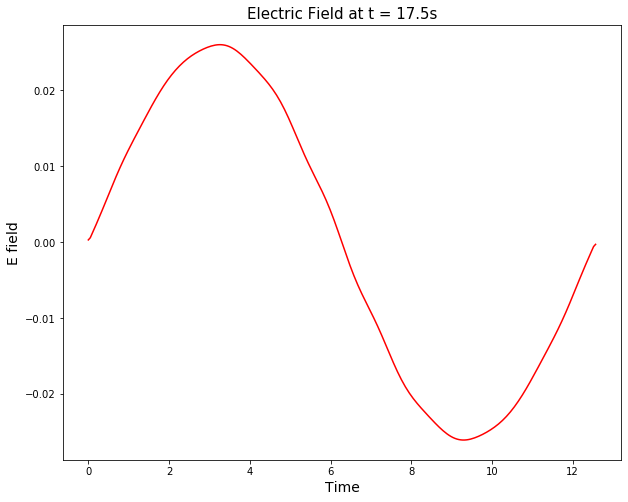

In [193]:
plt.figure(figsize=(10,8))
tt = 3000
plt.plot(x_array, E_field[tt],c='r')
plt.title(f'Electric Field at t = {tt*dt}s',fontsize=15)
plt.xlabel('Time',fontsize=14)
plt.ylabel('E field',fontsize=14)
plt.show()

#### We integrate the electric field vs position

Field Energy: 
$$ \int |\nabla \phi|^2 dx = \int |E(x)|^2 dx $$

In [200]:
integralEf = [integrate.trapz(abs(ef), dx = dx) for ef in E_field]

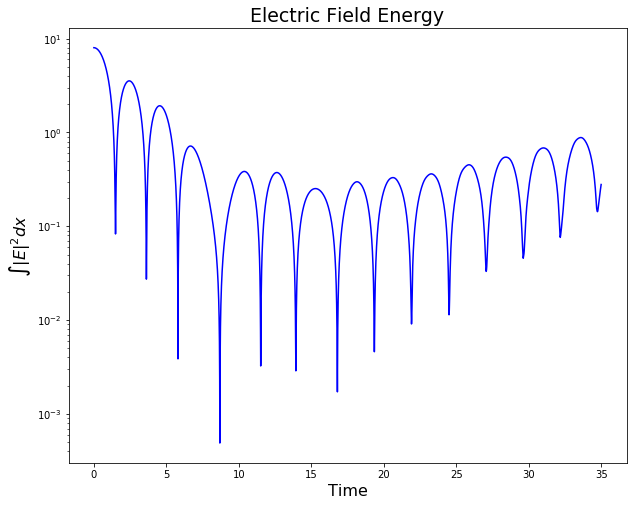

In [201]:
plt.figure(figsize=(10,8))
plt.plot(t_grid, integralEf,c='b')
plt.title('Electric Field Energy',fontsize=19)
plt.xlabel('Time',fontsize=16)
plt.ylabel('$\int|E|^2 dx$',fontsize=16)
plt.yscale('log')
plt.show()

## 2. Linear Landau Damping

Simulations for $k$ $\in (0.5,0.4,0.3,0.2)$ and $L_x = 2\pi/k$

#### Parameters

- $\varepsilon = 0.001$
- $k = (0.5,0.4,0.3,0.2)$
- $v\in(-10,10)$
- $x\in(0,2\pi/k)$

In [202]:
eps = 0.001 # perturbation parameter
v_min = -10 # Minimum velocity 
v_max = 10 # Maximum velocity
T_max = 30 # Max time of solution

# k param vector 
k_values = [0.5,0.4,0.3,0.2]

#### Discretization

In [203]:
N_x = 200 # Position Slots 
N_y = 210 # Velocities Slots 
M_size = 3500 # Divisions of time in M slots 

dv = (v_max-v_min)/N_y
dt = T_max/M_size

print(f'Ny: {N_y}    dy: {dv}')
print(f'M:  {M_size}   dt: {dt}')

Ny: 210    dy: 0.09523809523809523
M:  3500   dt: 0.008571428571428572


In [204]:
def error_func(y1,y2):
    '''Calculate the difference between to arrays'''
    y1 = np.array(y1)
    y2 = np.array(y2)
    if np.array(y1).shape == np.array(y2).shape:
        diff = y1-y2
        return diff
    else:
        print('Arrays must have the same dimension')

In [205]:
def calculate_norm(vector,norm_number):
    '''vector: Array or vector to which you want to determine the norm: 1,2 or inf
       norm_number: Norm order'''
    if type(norm_number) == str:
        return np.linalg.norm(vector,ord = float(norm_number))
    else:
        return np.linalg.norm(vector , ord = norm_number)

### Verification

These simulations can be verified by and approximated analytical solution of the electric field.

Analytical Solution to the model:

$$ E(x,t)\approx  - \frac{2 \varepsilon}{k} r e^{\omega_i t} \cos(\omega_rt - \phi) \sin(kx) $$

Table of solutions

| $k$ | $\omega_r$ | $\omega_i$ | $r$ | $\phi$ |
| --- | --- | --- | --- | --- |
| 0.5 | 1.4156 | -0.1533 | 0.3677 | 0.5362 |
| 0.4 | 1.2850 | -0.0661 | 0.4247 | 0.3358 |
| 0.3 | 1.1598 | -0.0126 | 0.6368 | 0.1143 |
| 0.2 | 1.0640 | -5.51e−5| 1.1297 | 0.0013 |

In [206]:
# Parameter values for each run
omega_r_values = [1.4156,1.2850,1.1598,1.0640]
omega_i_values = [-0.1533,-0.0661,-0.0126,-5.51e-5]
r_values = [0.3677,0.4247,0.6368,1.1297]
phi_values = [0.5362,0.3358,0.1143,0.0013]

In [207]:
def E_field_analytic(x,t,epsilon,k,r,omega_i,omega_r,phi):
    '''Analytical solution of the electric field at time t. It depends on various parameters:
        r, omega_i, omega_r, k, epsilon, and phi'''
    return  -2 * (epsilon/k) * r * np.exp(omega_i*t) * np.cos(omega_r*t - phi) * np.sin(k*x)

In [208]:
start_time = time.time()

Num_Efields = [] # List to store the numerical E fields
Anal_Efields = [] # List to store the analytical E fields
all_errors = [] # list to store the errors between solutions and analytical expressions

for idx,k_val in enumerate(k_values):

    Lx = 2*np.pi/k_val
    dx = Lx/N_x # Step Size
    
    landau_initial_cond = lambda x,v: (1.0/np.sqrt(2.0*np.pi)) * np.exp(-v**2/2.0) * (1.0 + eps*np.cos(k_val*x))
    
    # Create object
    objSolver = VlasovSolver.VlasovPoisson1D1V(landau_initial_cond, 0.0, Lx, N_x, v_min, v_max, N_y, T_max, M_size, 
                                                 'Spectral', 2, 'Landau_Damping2')
    Mass_sol,Moment_sol,Energy_sol,L2norm_sol,E_field = objSolver.run_iteration() # run model
    
    x_grid = objSolver.grid_points(0.0,Lx,dx) # Positions grid
    tim_grid = objSolver.grid_points(0.0,T_max,dt)[:-1] # Time grid
    
    # Create the analytical solutions for each time
    AnalyticEfield = np.array([E_field_analytic(x_grid, d_time, eps, k_val, r_values[idx], omega_i_values[idx],
                                                omega_r_values[idx], phi_values[idx]) for d_time in tim_grid])
    Num_Efields.append(E_field) # Store the electric fields for k=k_val
    Anal_Efields.append(AnalyticEfield) # Store the analytical electric fields for k=k_val

    errors_aux = [] # List to store errors between electric fields
    for i in range(len(AnalyticEfield)): # Iteration over the solutions of the electric field for all times
        diff = error_func(AnalyticEfield[i],E_field[i]) # Difference between arrays
        norm = calculate_norm(diff,2) # Norm 2 of the difference
        errors_aux.append(norm) # Store list of errors for the k_val value
        
    all_errors.append(errors_aux)
    
end_time = time.time()
print('Total execution time: ',(end_time-start_time)/60.)   

Total execution time:  17.7532728433609


### Plot the errors

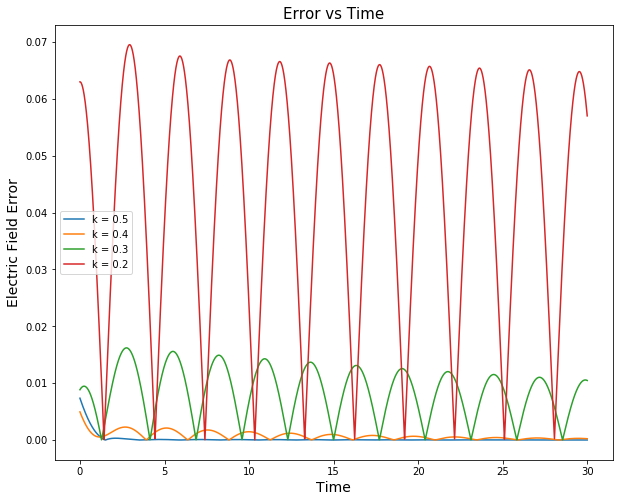

In [222]:
plt.figure(figsize=(10,8))
for idx,err in enumerate(all_errors):
    plt.plot(tim_grid,err,label = f'k = {k_values[idx]}')
plt.title("Error vs Time",fontsize=15)
plt.xlabel('Time',fontsize=14)
plt.ylabel('Electric Field Error',fontsize=14)
plt.legend()
plt.show()

### Calculate and plot the electric field energy 

In [230]:
dx_vals = [(2*np.pi/k_val)/N_x for k_val in k_values]
dx_vals

[0.06283185307179587,
 0.07853981633974483,
 0.10471975511965978,
 0.15707963267948966]

In [231]:
num_int = []
ana_int = []
for numE,analE,dxx in zip(Num_Efields,Anal_Efields,dx_vals):
    integralnum = [integrate.trapz(abs(ef), dx = dxx) for ef in numE]
    num_int.append(integralnum)
    integralanal = [integrate.trapz(abs(ef), dx = dxx) for ef in analE]
    ana_int.append(integralanal)

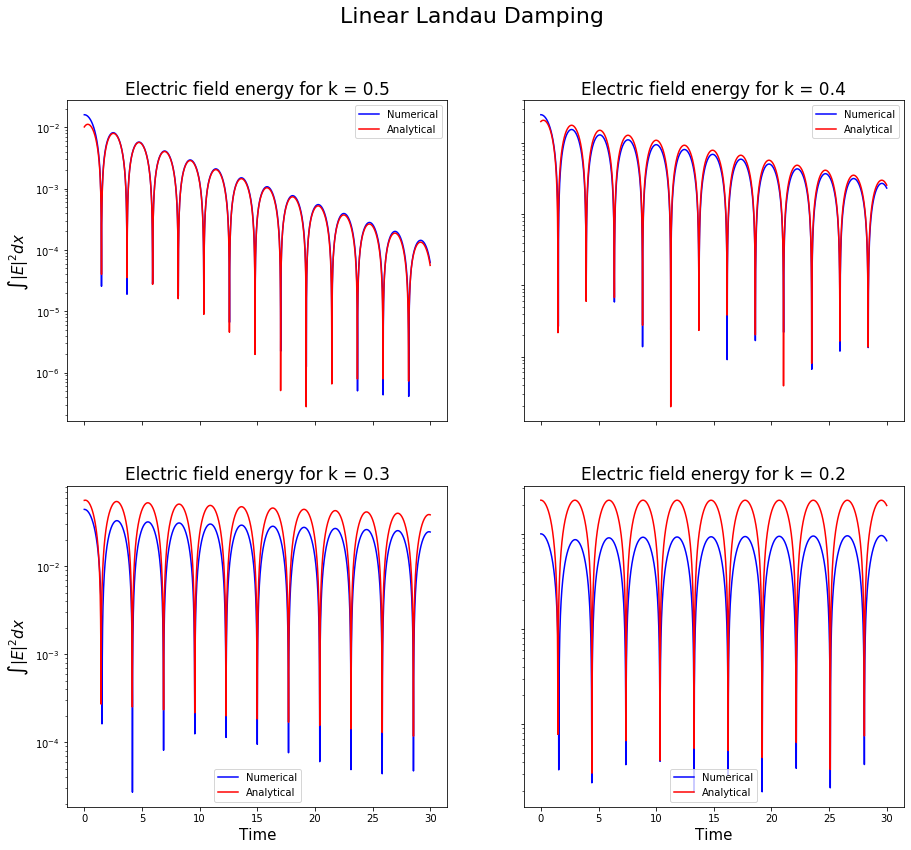

In [248]:
### Create plots of the distribution function at different times
fig, ax = plt.subplots(2, 2,figsize=(15,13))
fig.suptitle('Linear Landau Damping',fontsize = 22) # general title

ti = 0 # index counter

for i in range(2): 
    for j in range(2):
        
        ax[i,j].plot(tim_grid,num_int[ti],c = 'b' , label = 'Numerical') # plot numerical solution
        ax[i,j].plot(tim_grid,ana_int[ti],c = 'r' , label = 'Analytical') # plot analytical solution
        ax[i,j].set_title(f'Electric field energy for k = {k_values[ti]}',fontsize = 17) # create title

        ti+=1 
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Time',fontsize = 15)
    axx.set_ylabel('$\int|E|^2 dx$',fontsize = 15)
    axx.set_yscale('log')
    axx.legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()